<a href="https://colab.research.google.com/github/amber3536/Wildfire_Prediction/blob/Fire_chip/FireChip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
from concurrent.futures import ThreadPoolExecutor
from datetime import datetime, timedelta
import os
from pathlib import Path
from random import sample
import shutil
import subprocess
import math
import pyproj
import json

import shapely.wkt
from shapely.geometry import Polygon
import geopandas as gpd
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from shapely.geometry import box
from geocube.api.core import make_geocube
import rasterio
from rasterio.errors import RasterioIOError
from sklearn.cluster import DBSCAN
from pyproj import CRS
from shapely.geometry import mapping, MultiPoint, shape
from shapely.ops import transform, nearest_points
from shapely.ops import transform as shapely_tf

In [110]:
urls = []
for i in range(10):
    year = 2012 + i
    u = "https://firms.modaps.eosdis.nasa.gov/data/country/viirs-snpp/" + str(year) + "/viirs-snpp_" + str(year) + "_United_States.csv"
    urls.append(u)

In [293]:
def cluster_fires(fire_dataframe, min_cluster_points=25):
    """
    Given a geodataframe of fire points, for each date, create clusters
    :param fire_dataframe: geodataframe of fire points
    :param min_cluster_points: minimum number of fire points in a cluster for it to be kept
    :return: geodataframe of fire points that belong to a cluster
    """
    clustered_fires_for_dates = []
    number_of_clusters = 0
    for date in fire_dataframe["acq_date"].unique().tolist():
        fires_for_date = fire_dataframe[fire_dataframe["acq_date"] == date]
        fire_clusters = DBSCAN(eps=0.01, min_samples=1).fit(
            fires_for_date[["longitude", "latitude"]].values
        )
        # add clusters label
        cluster_labels = fire_clusters.labels_ + number_of_clusters
        number_of_clusters += fire_clusters.labels_.max()

        cluster_labels = pd.Series(cluster_labels, name="label")
        # shift to match date selection
        cluster_labels.index += fires_for_date.index.min()
        clustered_fires_for_dates.append(
            pd.concat([fires_for_date, cluster_labels], axis=1)
        )

    clustered_fires = pd.concat(clustered_fires_for_dates)
    # drop clusters with < min_cluster_points
    label_counts = clustered_fires["label"].value_counts()
    clustered_fires["label"] = clustered_fires["label"].apply(
        lambda x: x if label_counts[x] >= min_cluster_points else -1
    )
    clustered_fires = clustered_fires[clustered_fires["label"] != -1]

    # reset label to be continuous
    clustered_fires['label'] = clustered_fires.groupby('label').ngroup()
    return clustered_fires


def convert_wgs_to_utm(lon, lat):
    """
    Stolen from
    https://stackoverflow.com/questions/40132542/get-a-cartesian-projection-accurate-around-a-lat-lng-pair
    :param lon: Longitude float
    :param lat: Latitude float
    :return: The utm code appropriate for this AOI
    """
    utm_band = str((math.floor((lon + 180) / 6) % 60) + 1)
    if len(utm_band) == 1:
        utm_band = "0" + utm_band
    if lat >= 0:
        epsg_code = "326" + utm_band
        return epsg_code
    epsg_code = "327" + utm_band
    return epsg_code


def buffer_point(point, buffer_m=16000, output_4326=False):
    """
    Given a WGS 84 shapely point, figure out UTM proj for it, reproject point to that utm,
    buffer it and return the bounding box
    :param point: shapely point in EPSG:4326
    :param buffer_m: metres to buffer the point by
    :param output_4326: bool, should the buffered polygon be converted back to EPSG:4326
    :return: shapely polygon and the UTM CRS for it
    """
    epsg_code = int(convert_wgs_to_utm(point.x, point.y))
    utm_crs = CRS.from_epsg(epsg_code)

    # project point 4326 to utm
    wgs84_to_utm_transformer = pyproj.Transformer.from_proj(
        pyproj.Proj(4326),  # source coordinate system
        utm_crs,  # destination coordinate system
        always_xy=True,
    )
    projected_point = transform(wgs84_to_utm_transformer.transform, point)

    # buffer point
    buffered_point = projected_point.buffer(buffer_m).bounds
    bbox = box(
        minx=buffered_point[0],
        miny=buffered_point[1],
        maxx=buffered_point[2],
        maxy=buffered_point[3],
    )

    if output_4326:
        # reproject polygon back to 4326
        utm_to_wgs84_transformer = pyproj.Transformer.from_proj(
            utm_crs, pyproj.Proj(4326)  # source coordinate system
        )  # destination coordinate system
        bbox = transform(utm_to_wgs84_transformer.transform, bbox)

    return bbox, utm_crs


def create_chip_bounds(clustered_fires):
    """
    Given a geodataframe of clustered fire points create chip bbox and save metadata to csv
    :param clustered_fires: geodataframe of clustered fire points
    :param output_fp: directory for output file to be written to
    :return: filepath of the records.csv created/updated
    """
    chip_bounds = []
    for cluster in clustered_fires["label"].unique().tolist():
        clustered_fire = clustered_fires[clustered_fires["label"] == cluster]
        date = clustered_fire["acq_date"].values[0]
        multipoint_fire_feature = MultiPoint([x for x in clustered_fire.geometry])
        # convert to polygon & get centre
        multipoint_fire_feature_centre = multipoint_fire_feature.convex_hull.centroid
        # get closest point to centre
        central_fire_point = nearest_points(
            multipoint_fire_feature, multipoint_fire_feature_centre
        )[0]

        # build bbox around the clusters central fire point
        bbox_4326, utm_crs = buffer_point(
            central_fire_point, buffer_m=15750, output_4326=True
        )
        bbox_4326_geojson = json.dumps(
            mapping(transform(lambda x, y: (y, x), bbox_4326))
        )
        chip = make_geocube(
            vector_data=gpd.GeoDataFrame(
                geometry=[central_fire_point], crs="EPSG:4326"
            ),
            resolution=(-500, 500),
            output_crs=utm_crs,
            geom=bbox_4326_geojson,
        )

        chip_bounds.append([cluster, *chip.rio.bounds(), utm_crs.to_epsg(), date])

    return pd.DataFrame(
        chip_bounds, columns=["idx", "left", "bottom", "right", "top", "epsg", "date"]
    )


def fires_from_topleft(top_left, epsg_code, date_to_query, fires):
    """
    Given input chip parameters, load fire data and rasterize the points
    :param top_left: list of the top left coordinates of the chip
    :param epsg_code: EPSG code for top_left
    :param date_to_query: date of the fire data to load
    :param fires : gpd.GeoDataFrame or filename
    :return: xarray.Dataset containing rasterized fire points
    """
    aoi = bounds_to_geojson(
        rasterio.coords.BoundingBox(
            left=top_left[1],
            right=top_left[1] + 32000,
            bottom=top_left[0] - 32000,
            top=top_left[0],
        )
    )

    # reproj the bbox from utm to 4326
    utm_to_wgs84_transformer = pyproj.Transformer.from_crs(
        epsg_code, 4326, always_xy=True
    ).transform
    aoi_wgs84 = shapely_tf(utm_to_wgs84_transformer, shape(aoi))

    #print(aoi_wgs84)

    # load fire data intersecting chip bbox
    if isinstance(fires, str):
        fires_in_chip = gpd.read_file(fires, layer="merge", bbox=aoi_wgs84)
    else:
        chip_poly = gpd.GeoDataFrame(geometry=[aoi_wgs84], crs="EPSG:4326")
        m = fires[fires["acq_date"] == chip_date]
        j = m['geometry'].clip(chip_poly).keys()
        fires_in_chip = m.loc[j]
        #fires_in_chip = fires[fires["acq_date"] == date_to_query].clip(chip_poly)

    #fires_in_chip = fires_in_chip[fires_in_chip["acq_date"] == date_to_query]

    if fires_in_chip.empty:
        # possible if fire dies "next day"
        fires_in_chip = gpd.GeoDataFrame(geometry=[aoi_wgs84.centroid], crs="EPSG:4326")
        fires_in_chip["bool"] = 0
        fires_in_chip["frp"] = 0
    else:
        fires_in_chip["bool"] = 1
        fires_in_chip["frp"] = pd.to_numeric(fires_in_chip["frp"])


    bbox_4326, utm_crs = buffer_point(
        aoi_wgs84.centroid, buffer_m=15750, output_4326=True
    )
    bbox_4326_geojson = json.dumps(mapping(transform(lambda x, y: (y, x), bbox_4326)))

    # rasterize
    fire_array = make_geocube(
        vector_data=fires_in_chip,
        measurements=["bool", "frp"],
        resolution=(-500, 500),
        output_crs=epsg_code,
        fill=0,
        geom=bbox_4326_geojson,
    )
    return fire_array


def bounds_to_geojson(bounds):
    """
    Convert a rio BoundingBox to geojson with optional buffer
    :param bounds: BoundingBox
    :return: geojson with applied buffer
    """
    return {
        "type": "Polygon",
        "coordinates": [
            [
                [bounds.left, bounds.top],
                [bounds.right, bounds.top],
                [bounds.right, bounds.bottom],
                [bounds.left, bounds.bottom],
                [bounds.left, bounds.top],
            ]
        ],
    }


In [111]:
manifest = pd.DataFrame()
frames = []

for url in urls:
    new_df = pd.read_csv(url, low_memory=False)
    df_fire = gpd.GeoDataFrame(new_df, geometry=gpd.points_from_xy(new_df.longitude, new_df.latitude), crs='EPSG:4326')

    df_fire_clustered = cluster_fires(df_fire)
    frames.append(df_fire_clustered)

    chip_bounds = create_chip_bounds(df_fire_clustered)

    if manifest.empty:
        manifest=chip_bounds
    else:
        chip_bounds.idx = chip_bounds.idx + manifest.idx.max() + 1
        manifest = pd.concat([manifest, chip_bounds])


In [112]:
manifest.shape

(22825, 7)

In [113]:
manifest.head()

,idx,left,bottom,right,top,epsg,date
0,0,266000.0,2128500.0,298000.0,2160500.0,32605,2012-01-20
1,1,493000.0,3087500.0,525000.0,3119500.0,32617,2012-01-20
2,2,351500.0,3336000.0,383500.0,3368000.0,32617,2012-01-20
3,3,722000.0,3320000.0,754000.0,3352000.0,32616,2012-01-20
4,4,265500.0,2128500.0,297500.0,2160500.0,32605,2012-01-20


In [214]:
f = gpd.GeoDataFrame(frames[0])

In [209]:
def process(num):
  chip = manifest.iloc[num]
  chip_idx, left, bottom, top, right, epsg, chip_date = chip["idx"], chip["left"], chip["bottom"], chip["top"], chip["right"], chip["epsg"], chip["date"]
  bounds_utm = rasterio.coords.BoundingBox(left=left, right=right, bottom=bottom, top=top)
  geo = gpd.GeoSeries([box(*bounds_utm)])
  geo.crs = epsg
  sel = int(chip_date.split('-')[0]) - 2012
  fires = gpd.GeoDataFrame(frames[sel])
  todays_fires = fires_from_topleft([top, left], str(epsg), chip_date, fires)

  return todays_fires

In [183]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [298]:
first_5 = []

for i in range(5):
  first_5.append(process(i))

## Displaying first 5 fires

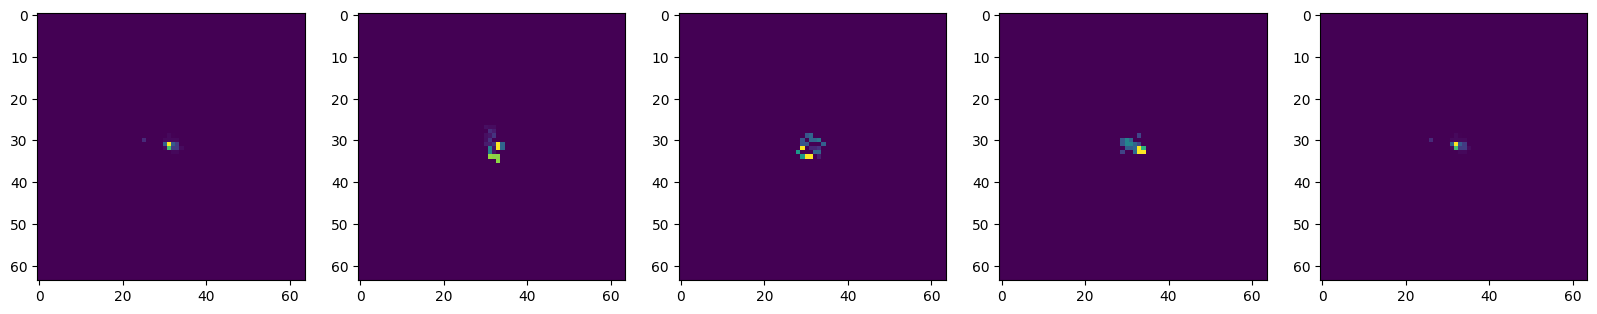

In [302]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,20))
im = ax1.imshow(first_5[0].frp)
im = ax2.imshow(first_5[1].frp)
im = ax3.imshow(first_5[2].frp)
im = ax4.imshow(first_5[3].frp)
im = ax5.imshow(first_5[4].frp)